<a href="https://colab.research.google.com/github/GiorgiaAuroraAdorni/ML-bachelor-course-assignments-sp23/blob/main/assignment%201/deliverable/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Student: Albert Cerfeda

--- 
# IMPORTANT: all the submitted code should be in 2 cells
1) How you trained, evaluated and saved your model
2) How to load your model from a file, load the data and evaluate the model. Cell 2) should be running independently (even if cell 1 is not run)

train.shape : (1400, 3)
test.shape : (600, 3)


== T1. LINEAR REGRESSION ==
MSE Train set:	0.4862
MSE Test set:	0.4812
Optimal theta:	[ 0.00205442  0.04163966  0.13865613 -1.21626924  0.05262409]


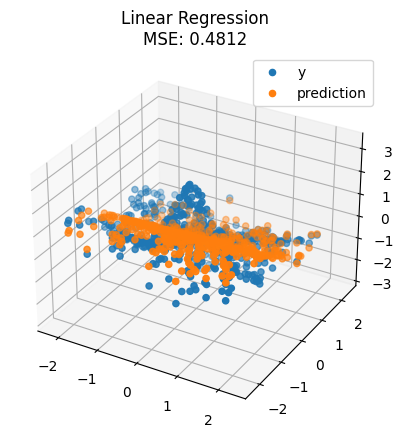

x_train_compact_polynomial.shape : (1400, 791)
x_train_compact.shape: (1400, 5)

== T2. Ridge ==
MSE Train set:	0.02
MSE Test set:	0.06


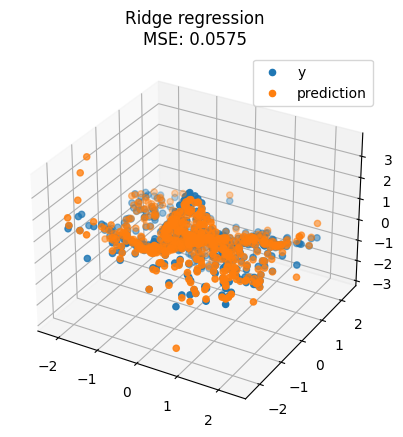

Epoch 1/1000
31/31 [==============================] - 0s 4ms/step - loss: 1.0138 - val_loss: 0.6185
Epoch 2/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.5410 - val_loss: 0.4861
Epoch 3/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4763 - val_loss: 0.4704
Epoch 4/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4688 - val_loss: 0.4596
Epoch 5/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4615 - val_loss: 0.4562
Epoch 6/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4543 - val_loss: 0.4447
Epoch 7/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4485 - val_loss: 0.4397
Epoch 8/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4448 - val_loss: 0.4308
Epoch 9/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4373 - val_loss: 0.4243
Epoch 10/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.4288 - val_loss: 0.4218

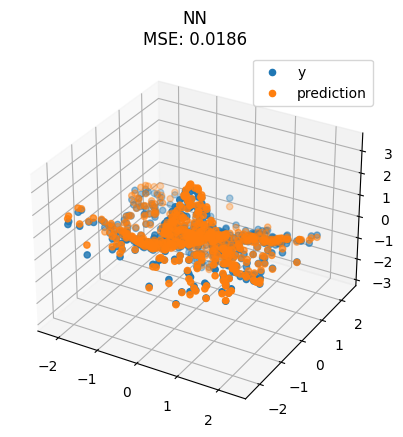

In [35]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt # Library for plotting
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense


# Load data 
data = np.load('../data/data.npz')

x = data.f.x
y = data.f.y.reshape(-1,1)


# T1 : Solving using sklearn.LinearRegression()
# Split data into training data and test data
# 0.7 means 70% of the data is used for training and 30% for testing
# We shuffle the data to grant the independetly and identically distributed properties of the data
train, test = train_test_split(np.hstack((x,y)), train_size=0.7, shuffle=True, random_state=0)

# We normalize the features around their mean and standard deviation
train = (train- train.mean(0)) / train.std(0)
test = (test- test.mean(0)) / test.std(0)

x_train = train[:, 0:2] 
y_train = train[:, -1] # The last row (the 3rd) is the feature we are trying to predict
x_test  = test[:, 0:2]
y_test  = test[:, -1]

# 2 features - 5 parameters
def compact_form(x):
    ones_vector = np.ones((x.shape[0],1))
    x = x.reshape(-1,2)
    return np.hstack((ones_vector, x[:,0].reshape(-1,1), x[:,1].reshape(-1,1), np.sin(x[:,1]).reshape(-1,1), (x[:,0]*x[:,1]).reshape(-1,1)))#.reshape(-1,5)

x_train_compact = compact_form(x_train)
x_test_compact = compact_form(x_test)
## Solving using sklearn.LinearRegression()
t1_d_linear_model = LinearRegression(fit_intercept=False)
t1_d_linear_model.fit(x_train_compact, y_train)
t1_theta = t1_d_linear_model.coef_.T
### Measure performance
#### Train set
t1_y_train_pred = t1_d_linear_model.predict(x_train_compact)
t1_y_train_mse = mean_squared_error(t1_y_train_pred, y_train)
#### Test set
t1_y_test_pred = t1_d_linear_model.predict(x_test_compact)
t1_y_test_mse = mean_squared_error(t1_y_test_pred, y_test)

## Printing / plotting ecc
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print("\n\n== T1. LINEAR REGRESSION ==")
print(f"MSE Train set:\t{t1_y_train_mse:.4f}")
print(f"MSE Test set:\t{t1_y_test_mse:.4f}")
print(f"Optimal theta:\t{t1_theta}")
# plot results
fig = plt.figure()
interval = np.linspace(0, 2, 1000).reshape(1000,1)
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0], x_test[:,1], y_test, label="y")
ax.scatter3D(x_test[:,0], x_test[:,1], t1_y_test_pred, label="prediction")
plt.title('Linear Regression\nMSE: {:.4f}'.format(t1_y_test_mse))
plt.legend()
plt.show()
fig.savefig('out/T1.predictions.png', bbox_inches='tight')
for i in range((len(t1_theta))):
    f = open(f"out/T1_theta_{i}.tex", "w")
    f.write(f"{t1_theta[i]:.5f}")
    f.close()
f = open("out/T1_MSE_Train.tex", "w")
f.write(f"{t1_y_train_mse:.5f}")
f.close()
f = open("out/T1_MSE_Test.tex", "w")
f.write(f"{t1_y_test_mse:.5f}")
f.close()

pickle.dump(t1_d_linear_model, open("./out/model_T1_pickle", 'wb'))

######################################
######################################

# T2 : Solving using PolynomialFeatures and Ridge regression
# Fit a polynomial of degree 7 to the data
pol_feat_high = PolynomialFeatures(degree=7, include_bias=False)
x_train_compact_polynomial = pol_feat_high.fit_transform(x_train_compact)
x_test_compact_polynomial = pol_feat_high.transform(x_test_compact)

# Ridge regression
t2_model = Ridge(alpha=1, fit_intercept=True)
t2_model.fit(x_train_compact_polynomial, y_train)
t2_theta = t2_model.coef_.T

### Measure performance
#### Train set
t2_y_train_pred = t2_model.predict(x_train_compact_polynomial)
t2_y_train_mse = mean_squared_error(t2_y_train_pred, y_train)
#### Test set
t2_y_test_pred = t2_model.predict(x_test_compact_polynomial)
t2_y_test_mse = mean_squared_error(t2_y_test_pred, y_test)


## Printing / plotting ecc
print('x_train_compact_polynomial.shape :', x_train_compact_polynomial.shape)
print('x_train_compact.shape:', x_train_compact.shape)
print("\n== T2. Ridge ==")
print(f"MSE Train set:\t{t2_y_train_mse:.2f}")
print(f"MSE Test set:\t{t2_y_test_mse:.2f}")
# plot results
fig = plt.figure()
interval = np.linspace(0, 2, 1000).reshape(1000,1)
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0], x_test[:,1], y_test, label="y")
ax.scatter3D(x_test[:,0], x_test[:,1], t2_y_test_pred, label="prediction")
plt.title('Ridge regression\nMSE: {:.4f}'.format(t2_y_test_mse))
plt.legend()
plt.show()
fig.savefig('out/T2.predictions.png', bbox_inches='tight')
f = open("out/T2_MSE_Train.tex", "w")
f.write(f"{t2_y_train_mse:.5f}")
f.close()
f = open("out/T2_MSE_Test.tex", "w")
f.write(f"{t2_y_test_mse:.5f}")
f.close()

pickle.dump(t1_d_linear_model, open("./out/model_T2_ridge.pickle", 'wb'))

# T3 (Bonus) : Neural Network
t3_NN = Sequential()
t3_NN.add(Dense(64, activation='elu', input_dim = 2))
t3_NN.add(Dense(64, activation='relu'))
t3_NN.add(Dense(64, activation='sigmoid'))
t3_NN.add(Dense(1, activation='linear'))
t3_NN.compile(optimizer='adamax', loss='mse')

t3_x_train, t3_x_val, t3_y_train, t3_y_val = train_test_split(x_train, y_train, train_size=0.7, shuffle=True, random_state=0)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
 
t3_NN.fit(t3_x_train, t3_y_train, epochs=1000, validation_data=(t3_x_val, t3_y_val), callbacks=[early_stop])
# Get the thetas
t3_theta = t3_NN.get_weights()

### Measure performance
#### Train set
t3_y_train_pred = t3_NN.predict(t3_x_train)
t3_y_train_mse = mean_squared_error(t3_y_train_pred, t3_y_train)
#### Test set
t3_y_test_pred = t3_NN.predict(x_test)
t3_y_test_mse = mean_squared_error(t3_y_test_pred, y_test)


## Printing / plotting ecc
print("\n== T3. NN ==")
print(f"MSE Train set:\t{t3_y_train_mse:.4f}")
print(f"MSE Test set:\t{t3_y_test_mse:.4f}")
# print(f"Optimal theta:\t{t2_theta}")
# plot results
fig = plt.figure()
interval = np.linspace(0, 2, 1000).reshape(1000,1)
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0], x_test[:,1], y_test, label="y")
ax.scatter3D(x_test[:,0], x_test[:,1], t3_y_test_pred, label="prediction")
plt.title('NN\nMSE: {:.4f}'.format(t3_y_test_mse))
plt.legend()
plt.show()
fig.savefig('out/T3.predictions.png', bbox_inches='tight')
f = open("out/T3_MSE_Train.tex", "w")
f.write(f"{t3_y_train_mse:.5f}")
f.close()
f = open("out/T3_MSE_Test.tex", "w")
f.write(f"{t3_y_test_mse:.5f}")
f.close()

pickle.dump(t3_NN, open("./out/model_T3_NN.pickle", 'wb'))

# Example on how to use baseline model:

In [2]:
# Import libraries
import joblib
import io
import requests
import numpy as np
import pickle

def evaluate_predictions(y_true, y_pred):
    """
    Evaluates the mean squared error between the values in y_true and the values
    in y_pred.
    ### YOU CAN NOT EDIT THIS FUNCTION ###
    :param y_true: Numpy array, the true target values from the test set;
    :param y_pred: Numpy array, the values predicted by your model.
    :return: float, the mean squared error between the two arrays.
    """
    print(y_true.shape, y_pred.shape)
    assert y_true.shape == y_pred.shape
    return ((y_true - y_pred) ** 2).mean()


def load_model(filename):
    """
    Loads a Scikit-learn model saved with joblib.dump.
    This is just an example, you can write your own function to load the model.
    Some examples can be found in src/utils.py.
    :param filename: string, path to the file storing the model.
    :return: the model.
    """
    model = joblib.load(filename)

    return model

# Load the data
# This will be replaced with our private test data when grading the assignment

# Load data from url
# url = 'https://drive.switch.ch/index.php/s/TeDwnbYsBKRuJjv/download'
# response = requests.get(url)
# data = np.load(io.BytesIO(response.content))

# Alternatively yo can load the data from file
data_path = '../data/data.npz'
data = np.load(data_path)

# x is a Numpy array of shape (n_samples, n_features) with the inputs
x = data.f.x
# y is a Numpy array of shape (n_samples, ) with the targets
y = data.f.y

# Load the trained model
baseline_model_path = "./out/model_T2_ridge.pickle"
baseline_model = pickle.load(open(baseline_model_path, 'rb'))


# Change input
# x = compact_form(x)

# Predict on the given samples
y_pred = baseline_model.predict(x)

############################################################################
# STOP EDITABLE SECTION: do not modify anything below this point.
############################################################################

# Evaluate the prediction using MSE
mse = evaluate_predictions(y_pred, y)
print(f'MSE on whole dataset: {mse}')

# NOTE: NOW THIS CELL IS NOT WORKING SINCE YOU NEED TO CHANGE THE INPUT.
# DO IT AND EVERYTHING RUNS SMOOTH


NameError: name 'compact_form' is not defined